# Mapping Housing Insecurity in Licking County


This file contains the code for creating a composite indicator map of housing insecurity within Licking County. 

In [54]:
#importing neccesary packages
import requests
import json
import io
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import censusdata
from tabulate import tabulate
import numpy as np

### Using the Census API to create a dataset for the census tracts in Licking County

Link to list of API variables: https://api.census.gov/data/2021/pdb/tract/variables.html


In [55]:
def censustract(variables, year, state):
    """
    This function constructs a query string and creates a dataset 
    
    requests census API for desired variables. Output is returned as pandas dataframe
    Parameters:
        variables: List of variable names from API you want to include in dataset
        year: The year of the data you wish to include in the dataset
        state: The state you wish to collect the census tract data from (the list of state values is here: https://api.census.gov/data/2019/acs/acs1?get=NAME,B01001_001E&for=state:*)
    """
    
   
    core = "https://api.census.gov/data/{}/pdb/tract".format(year)
    tract = "&for=tract:*"
    state = "&in=state:{}".format(state)
    
    getstring = ",".join(variables) #creating string from variables list
    getstring = "?get={}".format(getstring)
    querystring = core + getstring + tract + state

   
    df = pd.DataFrame(json.loads(requests.get(querystring).text))
    df.rename(columns = df.iloc[0], inplace = True)
    df = df.drop(df.index[0])
    

    return df.loc[:,~df.columns.duplicated()]

In [56]:
#choosing the variables for our dataset, from 2021 Ohio census data
censusdf = censustract(['state', 'County_name', 'GIDTR',"pct_Crowd_Occp_U_ACS_15_19", "pct_Renter_Occp_HU_ACS_15_19",
                     "pct_Prs_Blw_Pov_Lev_ACS_15_19", "pct_Civ_emp_16p_ACS_15_19"],2021, 39)

In [57]:
#creating a dataframe with only observations from Licking County
df= df.loc[censusdf["County_name"]=="Licking County"]

### Constructing a housing insecurity index using Census tract data

In [58]:
df["pct_Crowd_Occp_U_ACS_15_19"]=df["pct_Crowd_Occp_U_ACS_15_19"].astype(float)
df["pct_Renter_Occp_HU_ACS_15_19"]=df["pct_Renter_Occp_HU_ACS_15_19"].astype(float)
df["pct_Prs_Blw_Pov_Lev_ACS_15_19"]=df["pct_Prs_Blw_Pov_Lev_ACS_15_19"].astype(float)
df["pct_Civ_emp_16p_ACS_15_19"]=df["pct_Civ_emp_16p_ACS_15_19"].astype(float)

In [59]:
df["crowding_z"]= (df["pct_Crowd_Occp_U_ACS_15_19"]- df["pct_Crowd_Occp_U_ACS_15_19"].mean())/df["pct_Crowd_Occp_U_ACS_15_19"].std()

df["renter_z"]= (df["pct_Renter_Occp_HU_ACS_15_19"]- df["pct_Renter_Occp_HU_ACS_15_19"].mean())/df["pct_Renter_Occp_HU_ACS_15_19"].std()

df["unemploy_z"]= (df["pct_Civ_emp_16p_ACS_15_19"]- df["pct_Civ_emp_16p_ACS_15_19"].mean())/df["pct_Civ_emp_16p_ACS_15_19"].std()

df["pov_z"]= (df["pct_Prs_Blw_Pov_Lev_ACS_15_19"]- df["pct_Prs_Blw_Pov_Lev_ACS_15_19"].mean())/df["pct_Prs_Blw_Pov_Lev_ACS_15_19"].std()



df["hi_index"]= (df["pov_z"]*.25)+(df["unemploy_z"]*.25)+(df["renter_z"]*.25)+(df["crowding_z"]*.25)


In [60]:
df.to_csv("housinginsecurity.csv")

### Creating map

The shapefile for the census tracts in Licking County will be included in this Github repository, but are also available on the Census website: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2019&layergroup=Census+Tracts). 

In [61]:
street_map = gpd.read_file('tl_2019_39_tract.shp')
street_map['GEOID'] = pd.to_numeric(street_map['GEOID'])
tracts = pd.read_csv('housinginsecurity.csv')
tracts = tracts['GIDTR']
tracts = tracts.rename({'GIDTR': 'GEOID'})
tracts = tracts.to_list()
index = pd.read_csv('housinginsecurity.csv')
index = index.rename(columns={'GIDTR': 'GEOID'})
index = index[['GEOID','hi_index']]
street_map1 = gpd.GeoDataFrame(index)
street_map1 = street_map1.rename({'tract': 'TRACTCE'})


In [62]:
crs = {'init':'epsg:4326'}
geometry[:3]
street_map = street_map1.merge(street_map, how = 'inner', on = 'GEOID')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Housing Insecurity in Licking County')

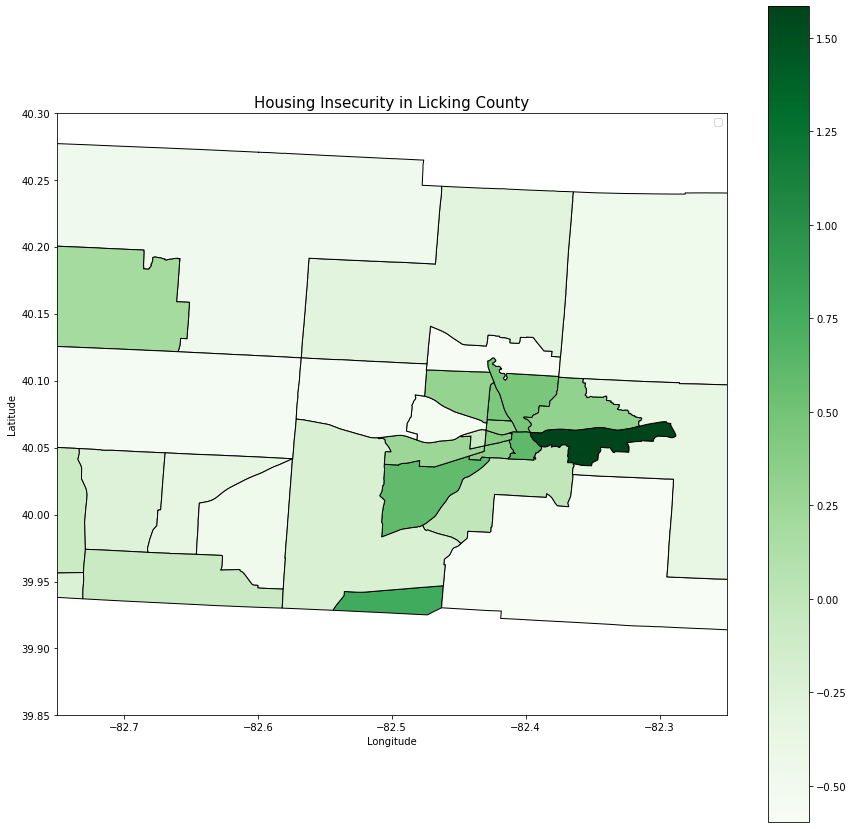

In [63]:
fig,ax=plt.subplots(figsize=(15,15))
ax.set_xlim([-82.75, -82.25])
ax.set_ylim([39.85, 40.30])
street_map.plot(ax=ax, column = 'hi_index', cmap = plt.get_cmap('Greens'), legend = True, edgecolor = 'black')

plt.legend(prop={'size':10})
ax.set_xlabel("Longitude", fontsize =10)
ax.set_ylabel("Latitude", fontsize = 10)
ax.set_title("Housing Insecurity in Licking County", fontsize =15)